In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from pyttn import generate_spanning_tree, generate_hierarchical_clustering_tree, convert_nx_to_tree, ntree
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [5]:
# This files is part of the pyTTN package.
# (C) Copyright 2025 NPL Management Limited
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License

import networkx as nx
import numpy as np
from math import ceil


def distance_matrix_to_graph(M):
    return nx.from_numpy_array(np.abs(M - np.diag(np.diag(M))))


def __insert_physical_nodes(spanning_tree, N, root_ind):
    # a function for taking a networkx tree generated from a max weight spanning tree of a graph
    # and inserts children nodes below each of the leaf nodes representing the physical tree nodes
    # additionally this shifts all indices stored in the tree so that they each have a unique label
    # and the new children nodes have the label that their parent used to have
    nindex = spanning_tree.number_of_nodes()

    # iterate over each node in the tree and determine whether we need to insert the child node
    # this is done by iterating over the tree in a depth first search order and determining if it
    # is a leaf node in the tree.  If it is we don't need to do anything, if it is not, then we will
    # insert a node beneath the present node and update its index

    #get a list of all nodes in the tree
    edges = sorted([edge for edge in nx.dfs_edges(
        spanning_tree, source=root_ind)], key=lambda x: np.abs(x[0]-root_ind))
    
    #determine the number of children each node has
    nchildren = [0 for x in range(N)]
    for i, e in enumerate(edges):
        if e[0] < N:
            nchildren[e[0]] += 1

    #and the total number of nodes that aren't leaf nodes

    mapping = {}      
    counter = 0  
    for i in range(nindex):
        if(i < N):
            if nchildren[i] == 0:
                mapping[i] = i
            else:
                mapping[i] = nindex+counter
                counter = counter+1
        else:
            mapping[i] = i


    # iterate over the tree and add nodes to any n
    nx.relabel_nodes(spanning_tree, mapping=mapping, copy=False)

    for i in range(N):
        if nchildren[i] > 0:
            spanning_tree.add_edge(mapping[i], i)
    print(mapping)
    return spanning_tree, mapping[root_ind]


def chunks(nodes, n):
    N = ceil(len(nodes)/n)
    for i in range(0, len(nodes), N):
        yield nodes[i:i + N]


def __split_node_mps(T, node, children, nindex, handle_leaves = False):
    curr_node = node
    if handle_leaves:
        if len(children) == 1:
            T.add_edge(curr_node, children[0])
        elif len(children) == 2:
            T.add_edge(curr_node, nindex)
            T.add_edge(nindex, children[0])
            T.add_edge(nindex, children[1])
            nindex += 1
        elif len(children) > 2:
            T.add_edge(curr_node, nindex)
            curr_node = nindex
            nindex += 1
            for cind in range(len(children)-2):
                T.add_edge(curr_node, children[cind])
                T.add_edge(curr_node, nindex)
                curr_node = nindex
                nindex += 1
            T.add_edge(curr_node, children[-2])
            T.add_edge(curr_node, children[-1])
    else:
        if len(children) > 0:
            for cind in range(len(children)-1):
                T.add_edge(curr_node, children[cind])
                T.add_edge(curr_node, nindex)
                curr_node = nindex
                nindex += 1
            T.add_edge(curr_node, children[-1])
    return T, nindex

def __split_node_branching(T, node, children, max_nchild, nindex, handle_leaves = False):
    curr_node = node
    if len(children) > max_nchild:
        if handle_leaves:
            T.add_edge(curr_node, nindex)
            curr_node = nindex
            nindex += 1
        # if the children list is longer than the maximum degree, iterate over creating up to max degree chunks
        for chunk in chunks(children, max_nchild):
            if len(chunk) == 1:
                T.add_edge(curr_node, chunk[0])
            else:
                # for each chunk
                nlabel = nindex
                T.add_edge(curr_node, nlabel)
                nindex += 1
                T, nindex = __split_node_branching(T, nlabel, chunk, max_nchild, nindex)
    else:
        if len(children) > 1 and handle_leaves:
            T.add_edge(curr_node, nindex)
            curr_node = nindex
            nindex += 1
            for child in children:
                T.add_edge(curr_node, child)           
        else:
            for child in children:
                T.add_edge(curr_node, child)
    return T, nindex

def __split_node(T, node, children, max_nchild, nindex, handle_leaves = False):
    if max_nchild is None: 
        for i in range(len(children)):
            T.add_edge(node, children[i])
    elif max_nchild > 1:
        T, nindex = __split_node_branching(T, node, children, max_nchild, nindex, handle_leaves=handle_leaves)
    elif max_nchild == 1:
        T, nindex = __split_node_mps(T, node, children, nindex, handle_leaves=handle_leaves)
    else:
        for i in range(len(children)):
            T.add_edge(node, children[i])

    return T, nindex


def __split_high_degree_nodes(spanning_tree, N, root_index, max_nchild=None, max_nleaves=None):
    if max_nchild is None and max_nleaves is None:
        # if max degree has not been specified we just return the current tree
        return spanning_tree
    else:
        # in this case iterate through the tree determine if any nodes are too large and if they are we partition
        # the node into sets of the correct size.  To do this we get a DFS edges list and if there are any instances
        # of nodes with more than max_nchild children we insert sufficiently many logical nodes so that we have the
        # correct degree of connectivity
        edges = sorted([edge for edge in nx.dfs_edges(
            spanning_tree, source=root_index)], key=lambda x: np.abs(x[0]-root_index))

        nchildren = {}
        nodes_to_split = {}

        curr_node = None
        sind = 0

        # iterate over the edges getting the number of children associated with each node and the location of the
        # first edge associated with a nodes children in the list
        for i, e in enumerate(edges):
            if curr_node != e[0]:
                curr_node = e[0]
                sind = i

            if curr_node not in nchildren.keys():
                nchildren[curr_node] = 1
            else:
                nchildren[curr_node] += 1

            if nchildren[curr_node] > max_nchild:
                if curr_node not in nodes_to_split.keys():
                    nodes_to_split[curr_node] = sind

        for i, e in enumerate(edges):
            if curr_node != e[1]:
                curr_node = e[1]

            if curr_node not in nchildren.keys():
                nchildren[curr_node]=0

        # if none of the nodes are high degree we don't need to do anything
        if len(nodes_to_split) == 0:
            return spanning_tree

        # otherwise we iterate through the tree and split high degree nodes off
        else:
            # now we split any nodes that need to be split
            counter = N
            T = nx.Graph()
            # if we are at a node we need to split
            for node, ind in nodes_to_split.items():
                nchild = nchildren[node]

                print([nchildren[edges[ind+i][1]] for i in range(nchild)])
                # get a list containing all of its children
                leaf_children = [edges[ind+i][1] for i in range(nchild) if nchildren[edges[ind+i][1]]==0]

                internal_children = [edges[ind+i][1] for i in range(nchild) if nchildren[edges[ind+i][1]]>0]
                print(edges[ind], leaf_children, internal_children)

                if max_nchild is None:
                    max_nchild = max_nleaves    

                if max_nleaves is None:
                    T, counter = __split_node(T, node, leaf_children+internal_children, max_nchild, counter)
                else:           
                    T, counter = __split_node(T, node, internal_children, max_nchild, counter)
                    T, counter = __split_node(T, node, leaf_children, max_nleaves, counter, handle_leaves=True)

            for e in edges:
                if e[0] not in nodes_to_split.keys():
                    T.add_edge(e[0], e[1])
            return T

[0, 0, 0, 0, 5]
(0, 1) [1, 2, 3, 4] [5]
[0, 0, 0, 0, 5]
(5, 6) [6, 7, 8, 9] [10]
[0, 0, 0, 0, 5]
(10, 11) [11, 12, 13, 14] [15]
[0, 0, 0, 0, 5]
(15, 16) [16, 17, 18, 19] [20]
[0, 0, 0, 0, 5]
(20, 21) [21, 22, 23, 24] [25]
[0, 0, 0, 0, 5]
(25, 26) [26, 27, 28, 29] [30]
[0, 0, 0, 0, 5]
(30, 31) [31, 32, 33, 34] [35]
[0, 0, 0, 0, 5]
(35, 36) [36, 37, 38, 39] [40]
[0, 0, 0, 0, 5]
(40, 41) [41, 42, 43, 44] [45]
[0, 0, 0, 0, 5]
(45, 46) [46, 47, 48, 49] [50]
[0, 0, 0, 0, 4]
(50, 51) [51, 52, 53, 54] [55]
[0, 0, 0, 0]
(55, 56) [56, 57, 58, 59] []
{0: 96, 1: 1, 2: 2, 3: 3, 4: 4, 5: 97, 6: 6, 7: 7, 8: 8, 9: 9, 10: 98, 11: 11, 12: 12, 13: 13, 14: 14, 15: 99, 16: 16, 17: 17, 18: 18, 19: 19, 20: 100, 21: 21, 22: 22, 23: 23, 24: 24, 25: 101, 26: 26, 27: 27, 28: 28, 29: 29, 30: 102, 31: 31, 32: 32, 33: 33, 34: 34, 35: 103, 36: 36, 37: 37, 38: 38, 39: 39, 40: 104, 41: 41, 42: 42, 43: 43, 44: 44, 45: 105, 46: 46, 47: 47, 48: 48, 49: 49, 50: 106, 51: 51, 52: 52, 53: 53, 54: 54, 55: 107, 56: 56, 57: 57,

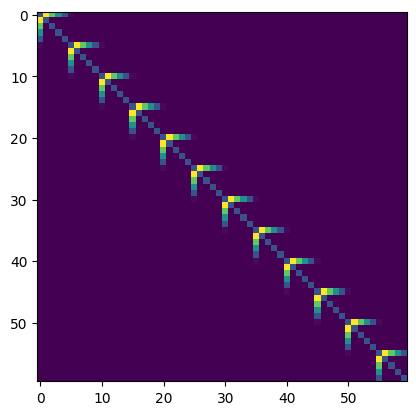

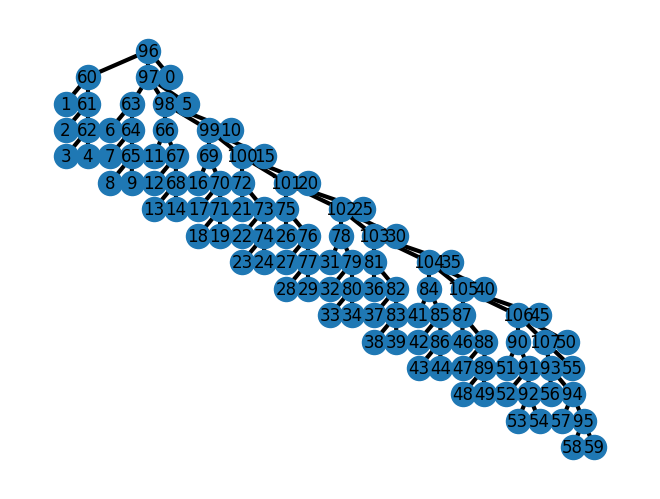

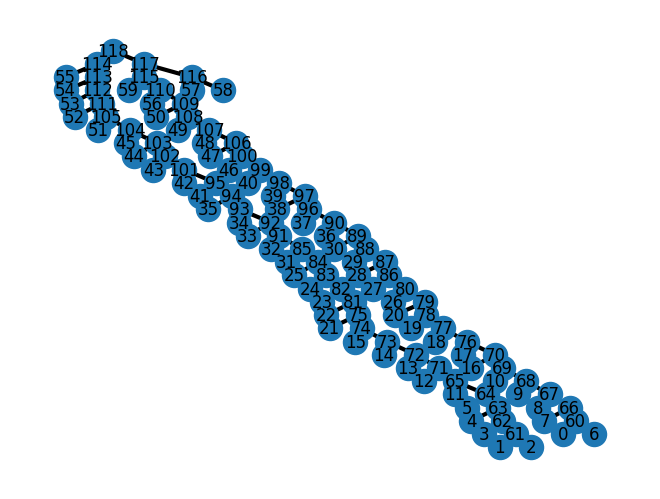

In [9]:
from pyttn.utils import visualise_tree


tree = ntree("(0(121))")
tree2 = ntree("(0(121))")

N = 4
M = 12
# G = nx.erdos_renyi_graph(N, 0.1)
# gamma = nx.to_numpy_array(G)
v = N-np.arange(N)  # np.random.uniform(0, 1, size=N)
w = np.diag(np.ones(N))  # np.random.uniform(0, 1, size=(N)))
w = (w + w.T)/2.0
gamma = np.zeros((N+1, N+1))
gamma[0, 0] = 1
gamma[0, 1:] = v
gamma[1:, 0] = v
gamma[1:, 1:] = w
# gamma += 1e-15

G2 = np.zeros((M*(N+1), M*(N+1)))
for i in range(M):
    G2[i*(N+1):(i+1)*(N+1), i*(N+1):(i+1)*(N+1)] = gamma

for i in range(M-1):
    G2[i*(N+1), (i+1)*(N+1)] = 0.1
    G2[(i+1)*(N+1), i*(N+1)] = 0.1


plt.figure(1)
plt.imshow(G2)

spanning_tree, spanning_root_ind = generate_spanning_tree(G2, max_internal_children=1, max_leaf_children=1, root_index=0)
print(spanning_tree)
clustering_tree, clustering_root_ind = generate_hierarchical_clustering_tree(G2)

tree, leaf_ordering = convert_nx_to_tree(
    spanning_tree, root_ind=spanning_root_ind)
print(leaf_ordering)
tree2, leaf_ordering2 = convert_nx_to_tree(
    clustering_tree, root_ind=clustering_root_ind)
print(leaf_ordering2)

plt.figure(2)
visualise_tree(tree, prog='dot')

plt.figure(3)
visualise_tree(tree2, prog='dot')

{0: 20, 1: 21, 2: 22, 3: 23, 4: 4, 5: 24, 6: 25, 7: 26, 8: 27, 9: 9, 10: 28, 11: 29, 12: 30, 13: 31, 14: 14, 15: 32, 16: 33, 17: 34, 18: 35, 19: 19}
Graph with 36 nodes and 35 edges
[19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[18, 16, 14, 12, 10, 8, 6, 4, 0, 2, 19, 17, 15, 13, 11, 9, 7, 5, 1, 3]


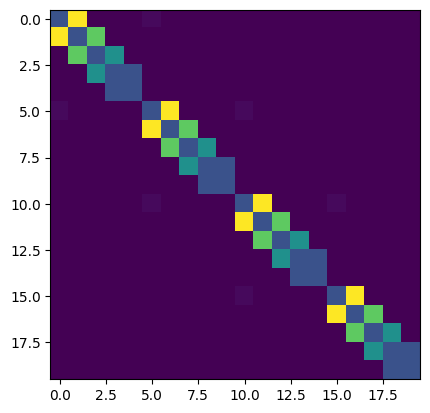

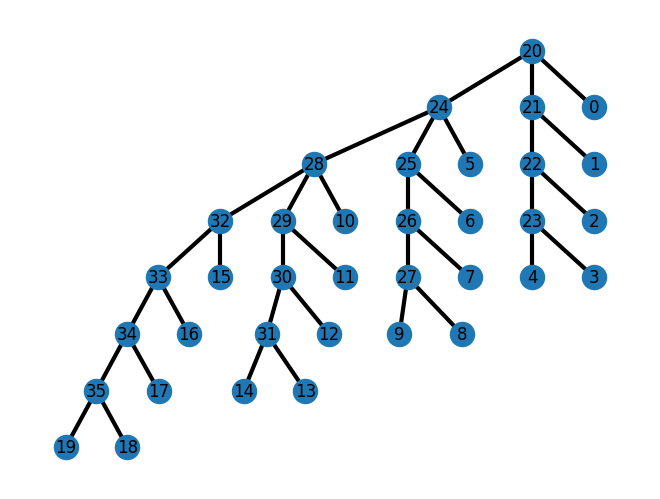

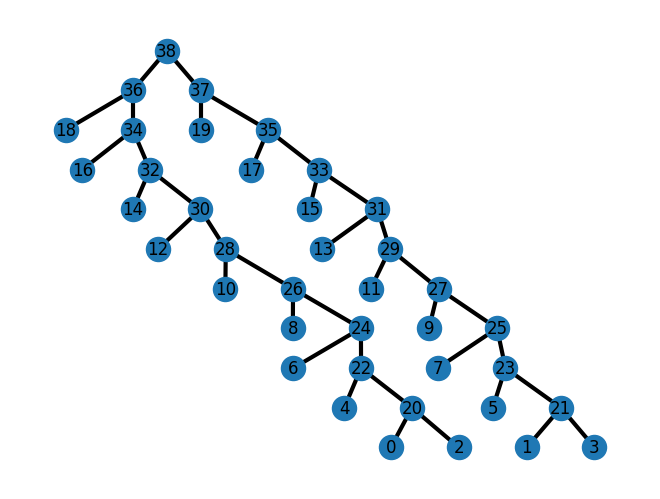

In [12]:
from pyttn.utils import visualise_tree


tree = ntree("(0(121))")
tree2 = ntree("(0(121))")

N = 4
M = 4
# G = nx.erdos_renyi_graph(N, 0.1)
# gamma = nx.to_numpy_array(G)
v = N-np.arange(N)  # np.random.uniform(0, 1, size=N)
w = np.diag(np.ones(N))  # np.random.uniform(0, 1, size=(N)))
w = (w + w.T)/2.0
gamma = np.zeros((N+1, N+1))
gamma[0, 0] = 1
gamma[1:, 1:] = w

for j in range(N):
    gamma[j, j+1] = v[j]
    gamma[j+1, j] = v[j]

#gamma[0, 1:] = v
#gamma[1:, 0] = v
# gamma += 1e-15

G2 = np.zeros((M*(N+1), M*(N+1)))
for i in range(M):
    G2[i*(N+1):(i+1)*(N+1), i*(N+1):(i+1)*(N+1)] = gamma

for i in range(M-1):
    G2[i*(N+1), (i+1)*(N+1)] = 0.1
    G2[(i+1)*(N+1), i*(N+1)] = 0.1


plt.figure(1)
plt.imshow(G2)

spanning_tree, spanning_root_ind = generate_spanning_tree(G2, root_index=0)
print(spanning_tree)
clustering_tree, clustering_root_ind = generate_hierarchical_clustering_tree(G2)

tree, leaf_ordering = convert_nx_to_tree(
    spanning_tree, root_ind=spanning_root_ind)
print(leaf_ordering)
tree2, leaf_ordering2 = convert_nx_to_tree(
    clustering_tree, root_ind=clustering_root_ind)
print(leaf_ordering2)

plt.figure(2)
visualise_tree(tree, prog='dot')

plt.figure(3)
visualise_tree(tree2, prog='dot')

ntree : (14(11(1)(8(5)(6)))(13(3)(12(9(2)(7))(10(0)(4)))));



{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [35.0, 35.0, 60.0, 60.0],
  [12.5, 12.5, 47.5, 47.5]],
 'dcoord': [[0.0, np.float64(0.0), np.float64(0.0), 0.0],
  [0.0,
   np.float64(1.1547005383792515),
   np.float64(1.1547005383792515),
   np.float64(0.0)],
  [0.0, np.float64(0.0), np.float64(0.0), 0.0],
  [0.0, np.float64(1.0), np.float64(1.0), 0.0],
  [np.float64(0.0),
   np.float64(2.1213203435596424),
   np.float64(2.1213203435596424),
   np.float64(1.0)],
  [0.0,
   np.float64(4.110960958218893),
   np.float64(4.110960958218893),
   np.float64(2.1213203435596424)],
  [np.float64(1.1547005383792515),
   np.float64(14.071839491220281),
   np.float64(14.071839491220281),
   np.float64(4.110960958218893)]],
 'ivl': ['1', '5', '6', '3', '2', '7', '0', '4'],
 'leaves': [1, 5, 6, 3, 2, 7, 0, 4],
 'color_list': ['C1', 'C1', 'C2', 'C2', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1

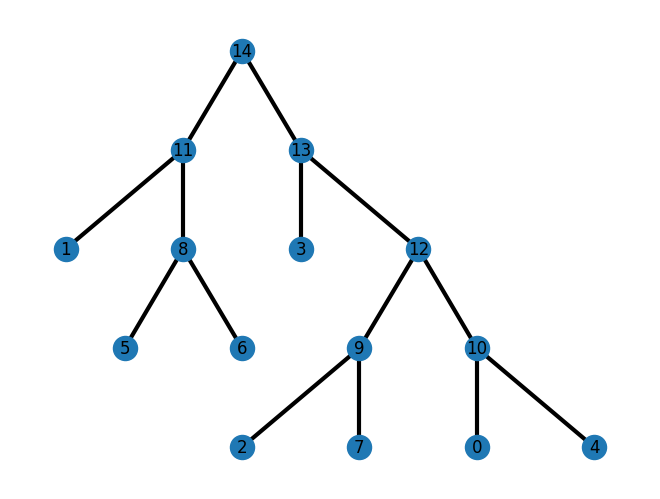

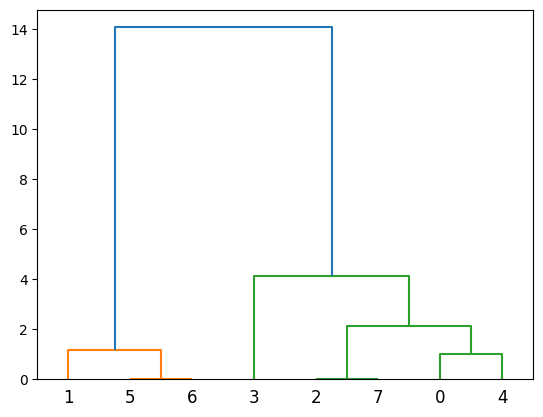

In [13]:
import networkx as nx
X = [2, 8, 0, 4, 1, 9, 9, 0]
M = np.zeros((len(X)*(len(X)-1))//2)
dist = np.zeros((len(X), len(X)))
c = 0
for i in range(len(X)):
    for j in range(i+1, len(X)):
        M[c] = np.abs(X[i]-X[j])
        dist[i, j] = np.abs(X[i]-X[j])
        c = c+1
for i in range(len(X)):
    for j in range(len(X)):
        dist[i, j] = np.abs(X[i]-X[j])
tree, root_ind = generate_hierarchical_clustering_tree(dist)
tree, leaf_ordering = convert_nx_to_tree(tree, root_ind=root_ind)

print(tree)
plt.figure(1)
visualise_tree(tree)
plt.figure(2)
Z = linkage(M, method='ward')
dendrogram(Z)